<a href="https://colab.research.google.com/github/laviniaflorentina/neural_networks_dissertation/blob/master/experiment2_cnn_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloads

In [0]:
import os.path
from IPython.display import clear_output

if not os.path.exists("data/train_minist.npz"):
  !wget https://github.com/laviniaflorentina/neural_networks_dissertation/raw/master/data/train_minist.npz
  clear_output(wait=True)

if not os.path.exists("validation_minist.npz"):
  !wget https://github.com/laviniaflorentina/neural_networks_dissertation/raw/master/data/validation_minist.npz
  clear_output(wait=True)

if not os.path.exists("test_minist.npz"):
  !wget https://github.com/laviniaflorentina/neural_networks_dissertation/raw/master/data/test_minist.npz
  clear_output(wait=True)

!ls

sample_data  test_minist.npz  train_minist.npz	validation_minist.npz


### Imports

In [0]:
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator



def plot_train(train_history, train=True, validation=True, acc_name='Model accuracy', loss_name='Model loss'):
  legend = []
  
  fig, ax = plt.subplots()
  
  fig.tight_layout()
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5)
  #fig.savefig(acc_name+".png", dpi=100)
  
  # summarize history for accuracy
  if train:
    plt.plot(history.history['acc'])
    legend.append('train')
    
  if validation:
    plt.plot(history.history['val_acc'])
    legend.append('validation')
    
  plt.grid()
  plt.title(acc_name)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.xticks((np.arange(len(history.history["acc"]))), 
             (np.arange(len(history.history["acc"]))+1))
  plt.show()
  
  fig.tight_layout()
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5)
  #fig.savefig(loss_name+".png", dpi=100)
  
  legend = []
  
  # summarize history for loss
  if train:
    plt.plot(history.history['loss'])
    legend.append('train')
    
  if validation:
    plt.plot(history.history['val_loss'])
    legend.append('validation')
    
  plt.grid()
  plt.title(loss_name)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.xticks((np.arange(len(history.history["acc"]))), 
             (np.arange(len(history.history["acc"]))+1))
  plt.show()
  
  return



def global_evaluation(true_labels, predicted_labels, avg='macro'):
  f1 = f1_score(true_labels, predicted_labels, average=avg)
  precision = precision_score(true_labels, predicted_labels, average=avg)
  recall = recall_score(true_labels, predicted_labels, average=avg)
  accuracy = accuracy_score(true_labels, predicted_labels)
  
  evaluation_table = pd.DataFrame({'Metric':["F1-score", "Precision", "Recall", "Accuracy"], "Value":[f1, precision, recall, accuracy] })
  
  return evaluation_table



def micro_evaluation(true_labels, predicted_labels, labels=list(range(10)), avg=None):
  f1 = f1_score(true_labels, predicted_labels, average=avg)
  precision = precision_score(true_labels, predicted_labels, average=avg)
  recall = recall_score(true_labels, predicted_labels, average=avg)
  evaluation_table = pd.DataFrame({'Labels':labels, "precision":precision, "recall":recall, "f1":f1 })
  
  return evaluation_table




def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         image="confusion_matrix.png"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig(image, dpi=100)
    return ax

Using TensorFlow backend.


### Read Data

In [0]:
npzfile = np.load("train_minist.npz")
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']

npzfile = np.load("validation_minist.npz")
X_validation = npzfile['arr_0']
y_validation = npzfile['arr_1']

npzfile = np.load("test_minist.npz")
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']

print("Train",X_train.shape)
print("Valid",X_validation.shape)
print("Test ",X_test.shape)

Train (3000, 28, 28)
Valid (3000, 28, 28)
Test  (10000, 28, 28)


### Augment Single Digit

In [0]:
rotation = 45
shift = 0.5
noise_range = 0

X_train_scaled = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]).astype('float32')

X_train_noisy = []
y_train_noisy = []

index =0
data_size = 40 * (len(X_train_scaled) - 1)

data_generator = ImageDataGenerator(
                             rotation_range=rotation, 
                             width_shift_range=shift, 
                             height_shift_range=shift, 
                             horizontal_flip=False, 
                             vertical_flip=False)

for batch_image, batch_label in data_generator.flow(X_train_scaled, y_train, batch_size=1):
    
  image = batch_image[0][0]
  label = batch_label[0]
  
  noise_lvl = random.randint(0, noise_range)
  noise = np.random.normal(1,noise_lvl, image.shape)
  
  X_train_noisy.append(image+noise)
  y_train_noisy.append(label)
  
  index +=1
  
  if index % 40000 == 0:
    print(index,data_size)
    
  if index == data_size:
    print("Done!")
    break
    
X_train_noisy = np.array(X_train_noisy)
y_train_noisy = np.array(y_train_noisy)

print(X_train_noisy.shape)


X_validation_scaled = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1], X_validation.shape[2]).astype('float32')

X_validation_noisy = []
y_validation_noisy = []

index =0
data_size = len(X_validation_scaled) - 1

data_generator = ImageDataGenerator(
                             rotation_range=rotation, 
                             width_shift_range=shift, 
                             height_shift_range=shift, 
                             horizontal_flip=False, 
                             vertical_flip=False)

for batch_image, batch_label in data_generator.flow(X_validation_scaled, y_validation, batch_size=1):
    
  image = batch_image[0][0]
  label = batch_label[0]
  
  noise_lvl = random.randint(0, noise_range)
  noise = np.random.normal(1,noise_lvl, image.shape)
  
  X_validation_noisy.append(image+noise)
  y_validation_noisy.append(label)
  
  index +=1
  
  if index % 1000 == 0:
    print(index,data_size)
    
  if index == data_size:
    print("Done!")
    break
    
X_validation_noisy = np.array(X_validation_noisy)
y_validation_noisy = np.array(y_validation_noisy)

print(X_validation_noisy.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (3000, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


40000 119960
80000 119960
Done!
(119960, 28, 28)
1000 2999
2000 2999
Done!
(2999, 28, 28)


#### Sample

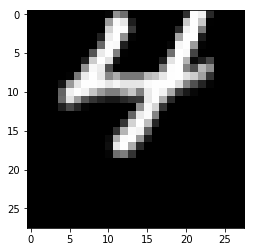

4


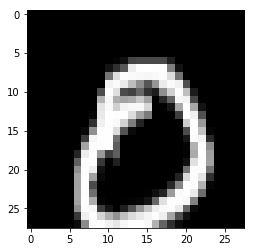

0


In [0]:
i = random.randint(0, 100)
# plot image
plt.imshow(X_train_noisy[i], cmap=plt.get_cmap('gray'))
plt.show()
# label
print(y_train_noisy[i])

# plot image
plt.imshow(X_validation_noisy[i], cmap=plt.get_cmap('gray'))
plt.show()
# label
print(y_validation_noisy[i])

### Model CNN Augmented

W0905 19:37:21.550157 140190555613056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 19:37:21.589678 140190555613056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 19:37:21.596988 140190555613056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0905 19:37:21.612798 140190555613056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0905 19:37:21.614178 1401905556

Train on 119960 samples, validate on 2999 samples
Epoch 1/20
119960/119960 [==============================] - 10s 84us/step - loss: 0.7980 - acc: 0.7442 - val_loss: 0.4546 - val_acc: 0.8570
Epoch 2/20
119960/119960 [==============================] - 7s 58us/step - loss: 0.3250 - acc: 0.8929 - val_loss: 0.3550 - val_acc: 0.8903
Epoch 3/20
119960/119960 [==============================] - 7s 58us/step - loss: 0.2383 - acc: 0.9194 - val_loss: 0.3403 - val_acc: 0.8960
Epoch 4/20
119960/119960 [==============================] - 7s 57us/step - loss: 0.1920 - acc: 0.9353 - val_loss: 0.3156 - val_acc: 0.9013
Epoch 5/20
119960/119960 [==============================] - 7s 57us/step - loss: 0.1618 - acc: 0.9453 - val_loss: 0.3161 - val_acc: 0.9056
Epoch 6/20
119960/119960 [==============================] - 7s 57us/step - loss: 0.1356 - acc: 0.9542 - val_loss: 0.3129 - val_acc: 0.9076
Epoch 7/20
119960/119960 [==============================] - 7s 57us/step - loss: 0.1191 - acc: 0.9590 - val_loss: 0

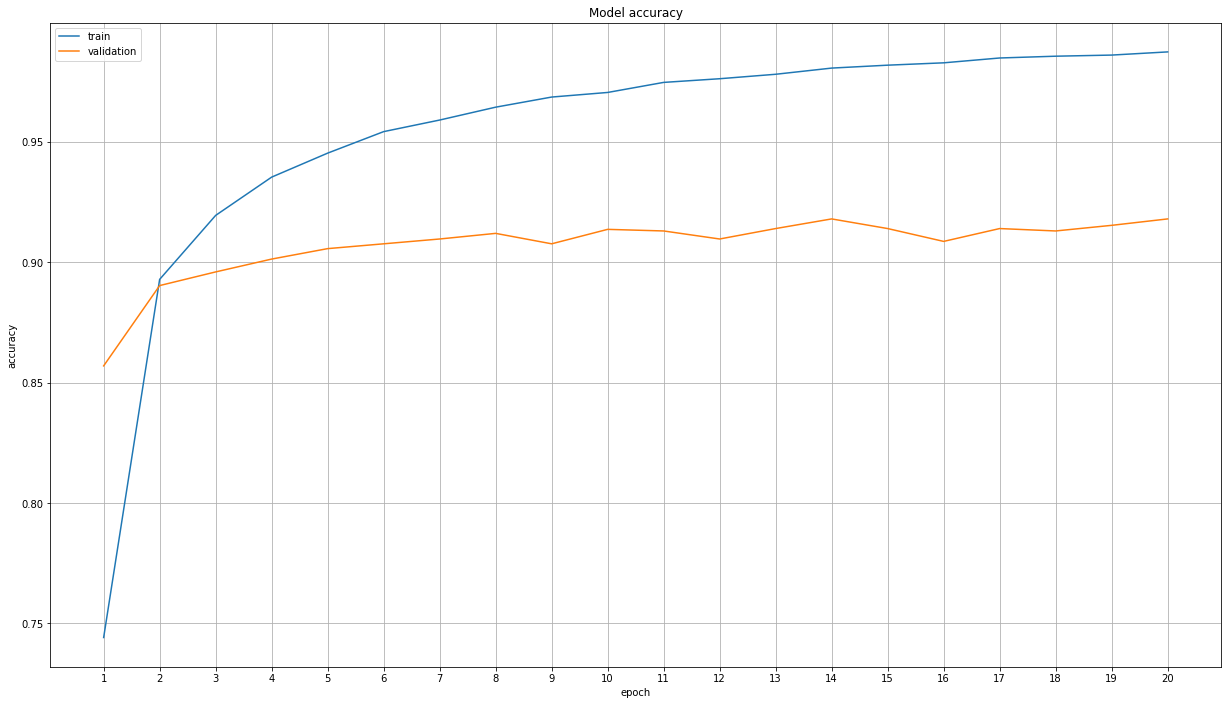

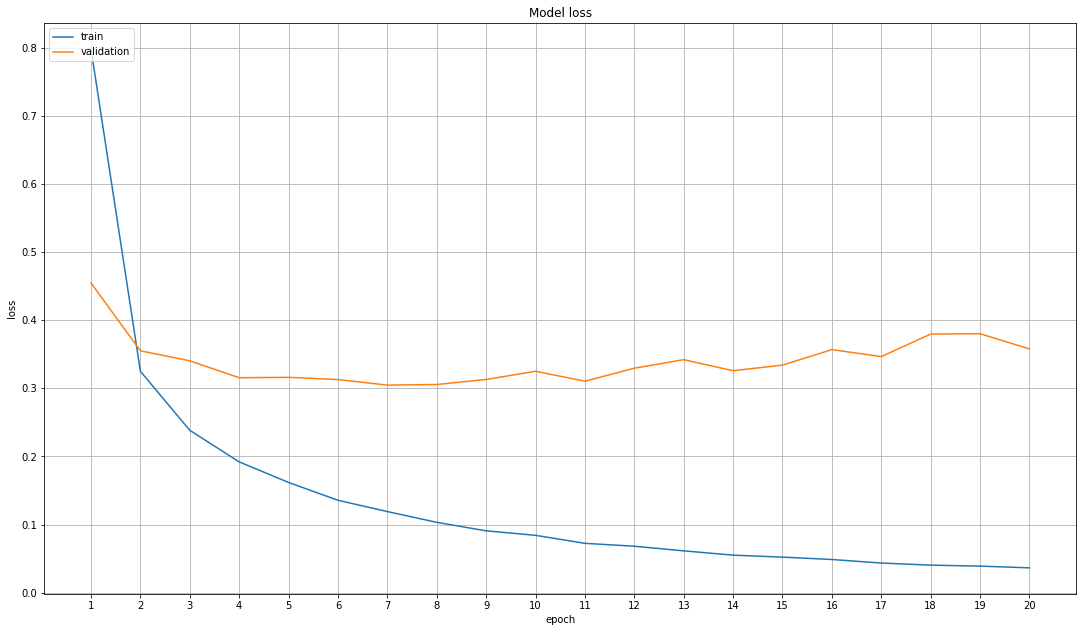

Confusion matrix, without normalization
[[ 948    2    5    2    2   11    3    0    4    3]
 [   0 1119    3    7    0    2    3    0    0    1]
 [   2    2  992   17    3    1    0    7    7    1]
 [   0    0    3  991    0    7    0    3    5    1]
 [   0    3    2    0  940    1    4    7    7   18]
 [   1    1    5    5    0  871    1    1    4    3]
 [   3    3    4    1   11   22  906    0    8    0]
 [   0    6   17    7   14    4    0  967    1   12]
 [   0    3    5    5    3    7    0    5  939    7]
 [   4    6    6   12   18   10    0   23   12  918]]
Normalized confusion matrix
[[9.67346939e-01 2.04081633e-03 5.10204082e-03 2.04081633e-03
  2.04081633e-03 1.12244898e-02 3.06122449e-03 0.00000000e+00
  4.08163265e-03 3.06122449e-03]
 [0.00000000e+00 9.85903084e-01 2.64317181e-03 6.16740088e-03
  0.00000000e+00 1.76211454e-03 2.64317181e-03 0.00000000e+00
  0.00000000e+00 8.81057269e-04]
 [1.93798450e-03 1.93798450e-03 9.61240310e-01 1.64728682e-02
  2.90697674e-03 9.689922

,Metric,Value
0,F1-score,0.958808
1,Precision,0.959072
2,Recall,0.958963
3,Accuracy,0.959100


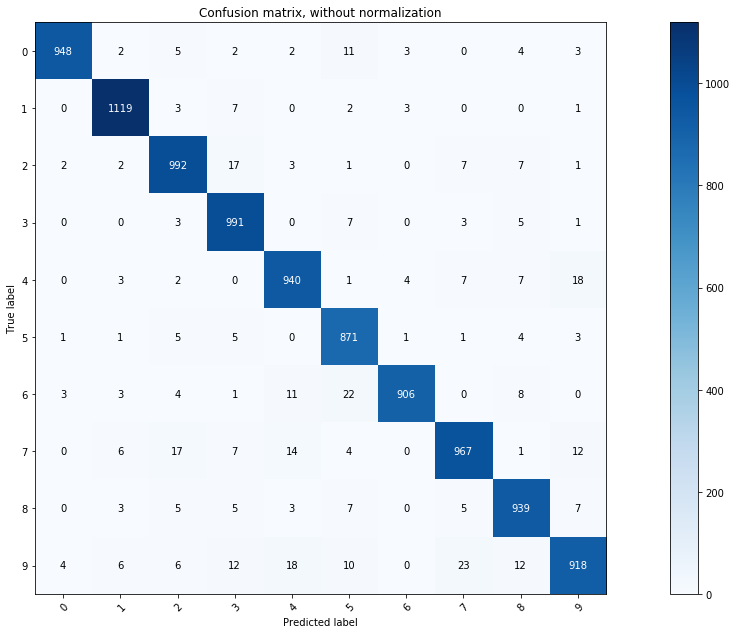

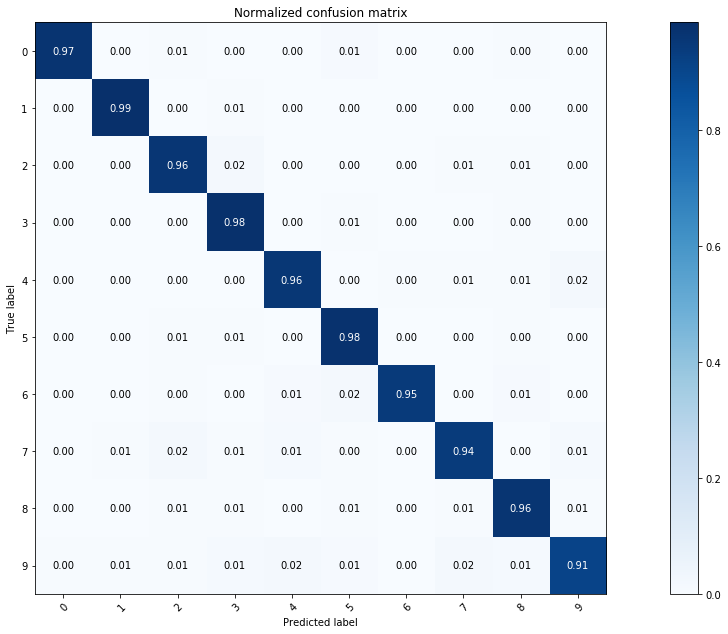

In [0]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
import random
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle


K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


def scale_data(images, labels, number_classes=100):

#   images, labels = shuffle(images, labels)
  
  scaled_images = images.reshape(images.shape[0], 1, images.shape[1], images.shape[2]).astype('float32')
  
  # normalize inputs from 0-255 to 0-1
  # importantfor NN - learn faster
  scaled_images = scaled_images / 255

  # one hot encode outputs
  scaled_labels = np_utils.to_categorical(labels, num_classes=number_classes)
  return scaled_images, scaled_labels

X_train_sc, y_train_sc = scale_data(images=X_train_noisy, labels=y_train_noisy)
X_valid_sc, y_valid_sc = scale_data(images=X_validation_noisy, labels=y_validation_noisy)
X_test_sc, _ = scale_data(images=X_test, labels=y_test)


# create model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=X_train_sc.shape[1:], activation='relu'))      # NOTA !!!! CONVOLUTION
model.add(MaxPooling2D(pool_size=(2, 2)))     # LAYER DE MICSORARE (IA PIXELUL CU VALOARE MAXIMA)
model.add(Dropout(0.2)) #seteaza valori pe zero random din matrici
model.add(Flatten()) # face orice dimensiune intr-un vector
model.add(Dense(128, activation='relu')) # NN normal layer
model.add(Dense(y_train_sc.shape[-1], activation='softmax')) # NN normal layer
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



history = model.fit(X_train_sc, y_train_sc, validation_data=(X_valid_sc, y_valid_sc), epochs=20, batch_size=200, verbose=1)

# plot history training
plot_train(train_history=history, 
           train=True, 
           validation=True)

# predicitons
y_predicted = model.predict_classes(X_test_sc)
y_predicted = np.array([number%10 for number in y_predicted])

plot_confusion_matrix(y_test, y_predicted, classes=np.array(range(10)), normalize=False, image="ex2_augmented_cnn_confusion_matrix_notnormalized.png")

plot_confusion_matrix(y_test, y_predicted, classes=np.array(range(10)), normalize=True, image="ex2_augmented_cnn_confusion_matrix_normalized.png")

baseline_cnn_global_evaluation = global_evaluation(y_test, y_predicted)

baseline_cnn_global_evaluation.to_csv("ex2_augmented_cnn_global_evaluation.csv")

baseline_cnn_global_evaluation

In [0]:
baseline_cnn_micro_evaluation = micro_evaluation(y_test, y_predicted)

baseline_cnn_micro_evaluation.to_csv("ex2_augmented_cnn_micro_evaluation.csv")

baseline_cnn_micro_evaluation

,Labels,precision,recall,f1
0,0,0.989562,0.967347,0.978328
1,1,0.977293,0.985903,0.981579
2,2,0.952015,0.961240,0.956606
3,3,0.946514,0.981188,0.963539
4,4,0.948537,0.957230,0.952864
5,5,0.930556,0.976457,0.952954
6,6,0.988004,0.945720,0.966400
7,7,0.954590,0.940661,0.947575
8,8,0.951368,0.964066,0.957675
9,9,0.952282,0.909812,0.930563


### Model diagram

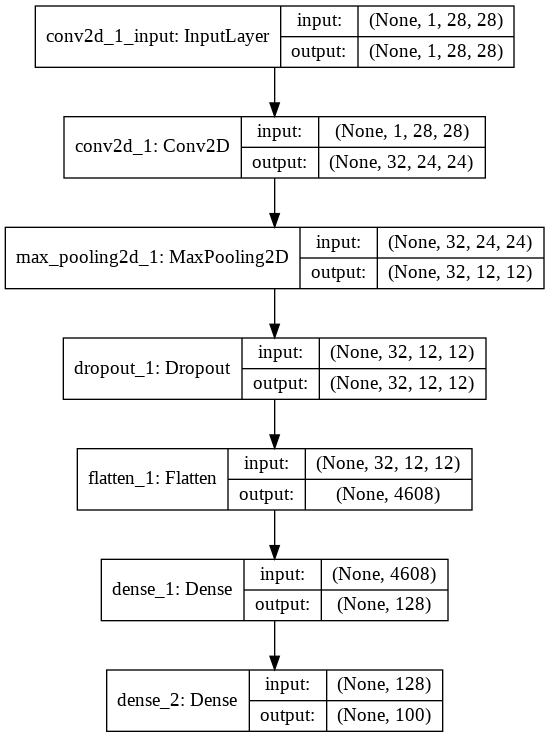

In [0]:
# image model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
Image('cnn_model.png')